# Particles

This notebook trains the diffusion model on a dataset of images of the 2D projections of the energy deposition patterns of four types of particles (electrons, photons, muons and protons) simulated in liquid argon medium. To download this dataset and for more information, see the notebook under datasets/particles.

In [1]:
# Import
from Diffusion import *
from utils import makedir
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import h5py as h5

torch.set_float32_matmul_precision('medium')

In [2]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_path = local_storage_dir + "Datasets/particles/if-image-train.h5"
checkpoint_dir = local_storage_dir + "Checkpoints/particles/"
log_dir = local_storage_dir + "Logs/particles/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(gif_dir)
num_channels = 1 # 1 for grayscale
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 128
batch_size = 32

In [3]:
# Load dataset
class hdf5Dataset(Dataset):
    def __init__(self, dataset_path, load_all=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.load_all = load_all
        if load_all:
            self.dataset = h5.File(dataset_path, 'r')['image'][:]
            self.dataset = self.dataset[:,None,:,:]
            self.dataset = torch.from_numpy(self.dataset).float()
        else:
            self.dataset = h5.File(dataset_path, 'r')['image']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.load_all:
            image = self.dataset[idx]
        else:
            image = self.dataset[idx][None,:,:]
            image = torch.from_numpy(image).float()
        if self.transform:
            image = self.transform(image)
        return image        

transform = transforms.Resize((image_size, image_size), antialias=True)

image_dataset = hdf5Dataset(dataset_path, load_all=False, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=16, pin_memory=True, persistent_workers=True)

In [4]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

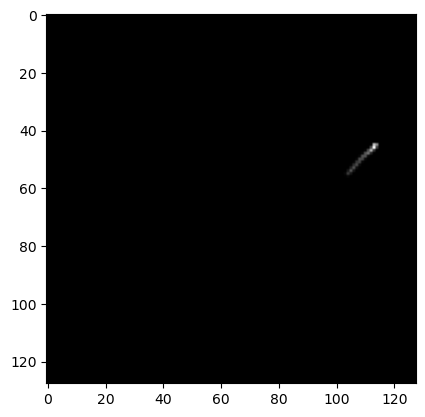

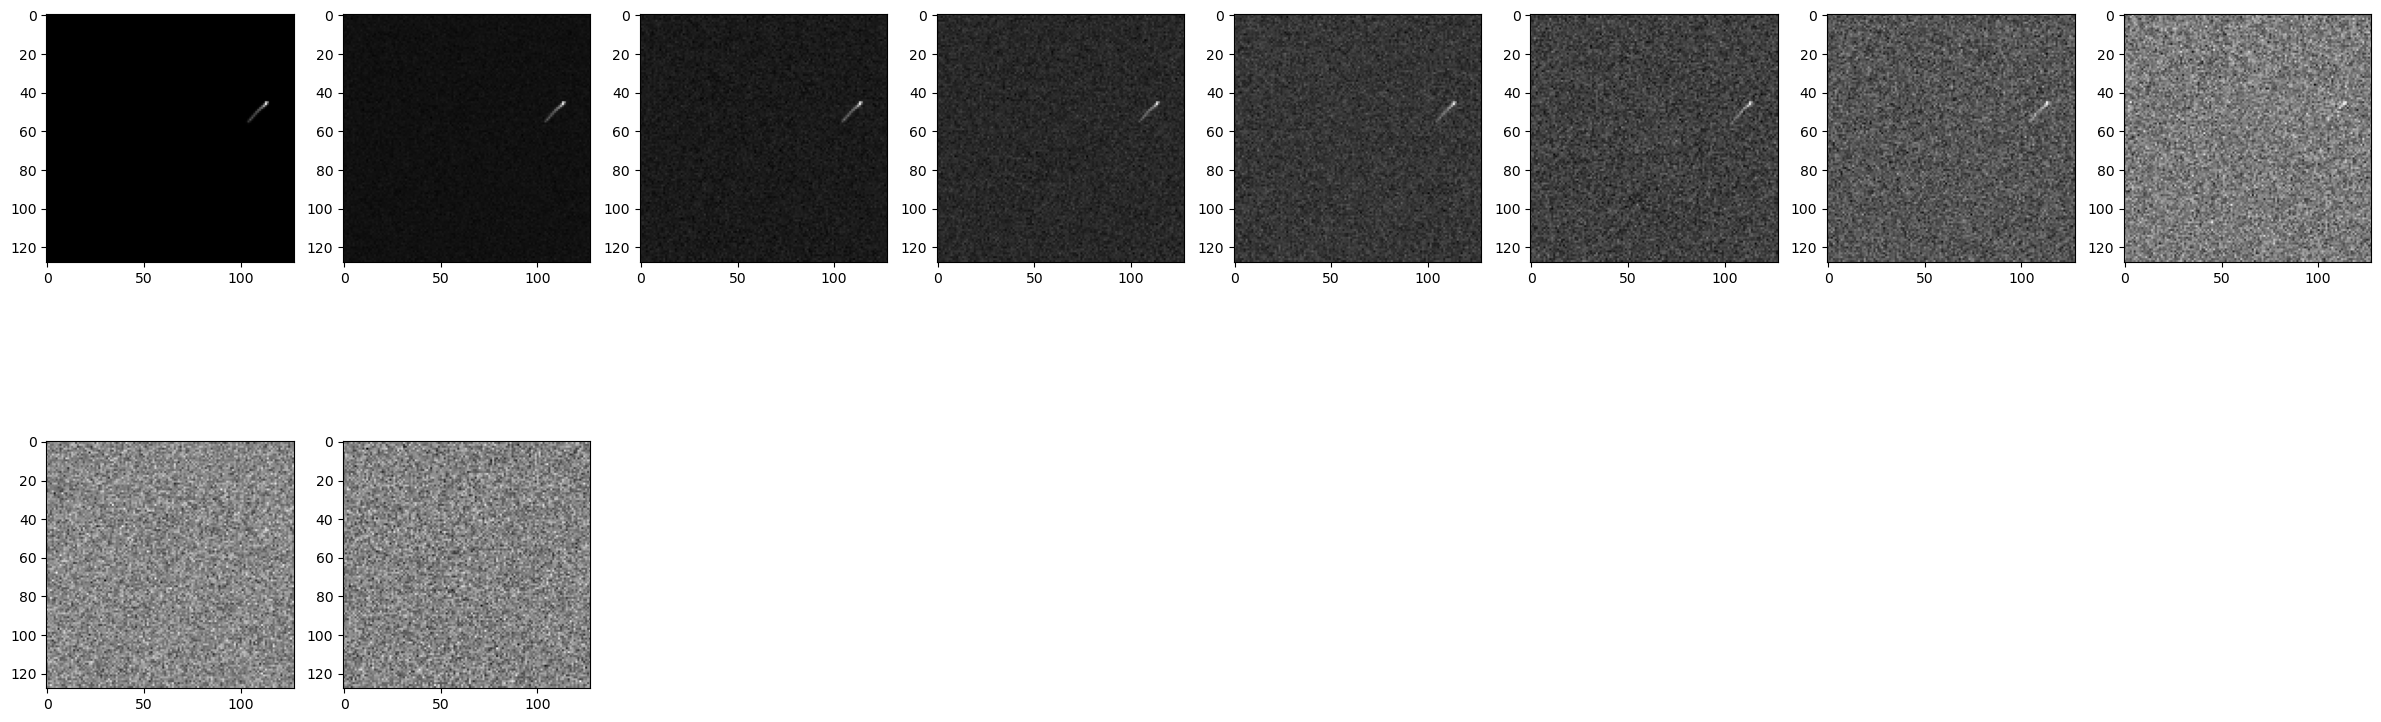

In [5]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]), cmap='gray')

plt.figure(figsize=(30,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for idx in range(0, num_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
    plt.imshow(image_from_tensor(tensor[0]), cmap='gray')

In [6]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=64,
    num_downsamples=5,
    num_mid_convs=1
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96, last_epoch=-1, verbose=False)

Num params:  249861889


In [7]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_epoch_35.pt", model, optimizer, lr_scheduler, start_epoch=36)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=60,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=5,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/12500 [00:00<?, ?it/s]/tmp/torchinductor_md775/zj/czj3ttvxehb2xrqd4bgbd3vsxupw7laaormyuh2utw7m2aj5ycpg.py:4840: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  buf0 = extern_kernels.convolution(primals_249, primals_1, stride=(1, 1), padding=(1, 1), dilation=(1, 1), transposed=False, output_padding=(0, 0), groups=1, bias=None)
100%|██████████| 12500/12500 [35:33<00:00,  5.86it/s, Epoch:=1, LR:=0.001, Loss:=0.0186]


Epoch: 1 Loss: 0.018614663690030574
LR: 0.00096


100%|██████████| 12500/12500 [34:31<00:00,  6.03it/s, Epoch:=2, LR:=0.00096, Loss:=0.0124]


Epoch: 2 Loss: 0.012357050991691649
LR: 0.0009216


100%|██████████| 12500/12500 [37:23<00:00,  5.57it/s, Epoch:=3, LR:=0.000922, Loss:=0.00951]


Epoch: 3 Loss: 0.00951137366592884
LR: 0.0008847359999999999


100%|██████████| 12500/12500 [37:22<00:00,  5.57it/s, Epoch:=4, LR:=0.000885, Loss:=0.00885]


Epoch: 4 Loss: 0.008847668577022851
LR: 0.0008493465599999999


100%|██████████| 12500/12500 [37:18<00:00,  5.58it/s, Epoch:=5, LR:=0.000849, Loss:=0.00857]


Epoch: 5 Loss: 0.008570278590470553
LR: 0.0008153726975999999


100%|██████████| 12500/12500 [37:22<00:00,  5.58it/s, Epoch:=6, LR:=0.000815, Loss:=0.00834]


Epoch: 6 Loss: 0.008344790411144495
LR: 0.0007827577896959998


100%|██████████| 12500/12500 [37:20<00:00,  5.58it/s, Epoch:=7, LR:=0.000783, Loss:=0.00818]


Epoch: 7 Loss: 0.008183224810287356
LR: 0.0007514474781081598


100%|██████████| 12500/12500 [37:19<00:00,  5.58it/s, Epoch:=8, LR:=0.000751, Loss:=0.00805]


Epoch: 8 Loss: 0.008052737847827375
LR: 0.0007213895789838333


100%|██████████| 12500/12500 [37:22<00:00,  5.57it/s, Epoch:=9, LR:=0.000721, Loss:=0.00797]


Epoch: 9 Loss: 0.007966686631664634
LR: 0.00069253399582448


100%|██████████| 12500/12500 [37:15<00:00,  5.59it/s, Epoch:=10, LR:=0.000693, Loss:=0.00787]


Epoch: 10 Loss: 0.007873408033773304
LR: 0.0006648326359915007


100%|██████████| 12500/12500 [37:14<00:00,  5.59it/s, Epoch:=11, LR:=0.000665, Loss:=0.00779]


Epoch: 11 Loss: 0.007788280078731477
LR: 0.0006382393305518406


100%|██████████| 12500/12500 [37:14<00:00,  5.60it/s, Epoch:=12, LR:=0.000638, Loss:=0.00774]


Epoch: 12 Loss: 0.007741505404002965
LR: 0.000612709757329767


100%|██████████| 12500/12500 [37:14<00:00,  5.59it/s, Epoch:=13, LR:=0.000613, Loss:=0.00768]


Epoch: 13 Loss: 0.007680063753165304
LR: 0.0005882013670365763


100%|██████████| 12500/12500 [37:14<00:00,  5.59it/s, Epoch:=14, LR:=0.000588, Loss:=0.00765]


Epoch: 14 Loss: 0.007647805908657611
LR: 0.0005646733123551131


100%|██████████| 12500/12500 [37:14<00:00,  5.59it/s, Epoch:=15, LR:=0.000565, Loss:=0.00756]


Epoch: 15 Loss: 0.007561815448962152
LR: 0.0005420863798609086


100%|██████████| 12500/12500 [37:12<00:00,  5.60it/s, Epoch:=16, LR:=0.000542, Loss:=0.00755]


Epoch: 16 Loss: 0.007545592853650451
LR: 0.0005204029246664722


100%|██████████| 12500/12500 [37:11<00:00,  5.60it/s, Epoch:=17, LR:=0.00052, Loss:=0.00749]


Epoch: 17 Loss: 0.007486434088982642
LR: 0.0004995868076798133


100%|██████████| 12500/12500 [37:15<00:00,  5.59it/s, Epoch:=18, LR:=0.0005, Loss:=0.00744]


Epoch: 18 Loss: 0.007439126500673592
LR: 0.0004796033353726208


100%|██████████| 12500/12500 [37:14<00:00,  5.60it/s, Epoch:=19, LR:=0.00048, Loss:=0.0074] 


Epoch: 19 Loss: 0.0074000826786831024
LR: 0.00046041920195771596


100%|██████████| 12500/12500 [37:15<00:00,  5.59it/s, Epoch:=20, LR:=0.00046, Loss:=0.00737]


Epoch: 20 Loss: 0.007368250483050943
LR: 0.0004420024338794073


100%|██████████| 12500/12500 [37:13<00:00,  5.60it/s, Epoch:=21, LR:=0.000442, Loss:=0.00732]


Epoch: 21 Loss: 0.0073171182388067245
LR: 0.00042432233652423104


100%|██████████| 12500/12500 [37:12<00:00,  5.60it/s, Epoch:=22, LR:=0.000424, Loss:=0.00731]


Epoch: 22 Loss: 0.007308405184485018
LR: 0.0004073494430632618


100%|██████████| 12500/12500 [35:45<00:00,  5.83it/s, Epoch:=23, LR:=0.000407, Loss:=0.00729]


Epoch: 23 Loss: 0.007285562090352178
LR: 0.0003910554653407313


100%|██████████| 12500/12500 [35:33<00:00,  5.86it/s, Epoch:=24, LR:=0.000391, Loss:=0.00724]


Epoch: 24 Loss: 0.007241869138143957
LR: 0.000375413246727102


100%|██████████| 12500/12500 [35:53<00:00,  5.80it/s, Epoch:=25, LR:=0.000375, Loss:=0.00722]


Epoch: 25 Loss: 0.007220129983611405
LR: 0.00036039671685801796


100%|██████████| 12500/12500 [34:22<00:00,  6.06it/s, Epoch:=26, LR:=0.00036, Loss:=0.00722]


Epoch: 26 Loss: 0.007221829023323953
LR: 0.00034598084818369723


100%|██████████| 12500/12500 [34:20<00:00,  6.07it/s, Epoch:=27, LR:=0.000346, Loss:=0.00722]


Epoch: 27 Loss: 0.007216221246123314
LR: 0.00033214161425634933


100%|██████████| 12500/12500 [34:22<00:00,  6.06it/s, Epoch:=28, LR:=0.000332, Loss:=0.00715]


Epoch: 28 Loss: 0.007146262417249381
LR: 0.00031885594968609533


100%|██████████| 12500/12500 [34:22<00:00,  6.06it/s, Epoch:=29, LR:=0.000319, Loss:=0.00712]


Epoch: 29 Loss: 0.0071211611813306805
LR: 0.0003061017116986515


100%|██████████| 12500/12500 [34:20<00:00,  6.07it/s, Epoch:=30, LR:=0.000306, Loss:=0.00711]


Epoch: 30 Loss: 0.007105895791873336
LR: 0.0002938576432307054


100%|██████████| 12500/12500 [34:22<00:00,  6.06it/s, Epoch:=31, LR:=0.000294, Loss:=0.0071]


Epoch: 31 Loss: 0.007099460560306907
LR: 0.0002821033375014772


100%|██████████| 12500/12500 [34:22<00:00,  6.06it/s, Epoch:=32, LR:=0.000282, Loss:=0.00706]


Epoch: 32 Loss: 0.007059738200120628
LR: 0.0002708192040014181


100%|██████████| 12500/12500 [34:23<00:00,  6.06it/s, Epoch:=33, LR:=0.000271, Loss:=0.00705]


Epoch: 33 Loss: 0.0070467247803509235
LR: 0.00025998643584136135


100%|██████████| 12500/12500 [34:24<00:00,  6.06it/s, Epoch:=34, LR:=0.00026, Loss:=0.00702]


Epoch: 34 Loss: 0.007021889765448868
LR: 0.0002495869784077069


100%|██████████| 12500/12500 [34:21<00:00,  6.06it/s, Epoch:=35, LR:=0.00025, Loss:=0.00703]


Epoch: 35 Loss: 0.007029783624783158
LR: 0.0002396034992713986


100%|██████████| 12500/12500 [34:23<00:00,  6.06it/s, Epoch:=36, LR:=0.00024, Loss:=0.007]  


Epoch: 36 Loss: 0.007003008704036474
LR: 0.00023001935930054264


100%|██████████| 12500/12500 [34:20<00:00,  6.07it/s, Epoch:=37, LR:=0.00023, Loss:=0.00699]


Epoch: 37 Loss: 0.006992861084081233
LR: 0.00022081858492852091


100%|██████████| 12500/12500 [34:20<00:00,  6.07it/s, Epoch:=38, LR:=0.000221, Loss:=0.00697]


Epoch: 38 Loss: 0.006966239457242191
LR: 0.00021198584153138007


100%|██████████| 12500/12500 [34:20<00:00,  6.07it/s, Epoch:=39, LR:=0.000212, Loss:=0.00695]


Epoch: 39 Loss: 0.0069498303086683155
LR: 0.00020350640787012485


100%|██████████| 12500/12500 [34:21<00:00,  6.06it/s, Epoch:=40, LR:=0.000204, Loss:=0.00695]


Epoch: 40 Loss: 0.0069468004288896915
LR: 0.00019536615155531985


100%|██████████| 12500/12500 [34:23<00:00,  6.06it/s, Epoch:=41, LR:=0.000195, Loss:=0.00694]


Epoch: 41 Loss: 0.006937673252075911
LR: 0.00018755150549310706


100%|██████████| 12500/12500 [36:46<00:00,  5.66it/s, Epoch:=42, LR:=0.000188, Loss:=0.0069] 


Epoch: 42 Loss: 0.006897897391468287
LR: 0.00018004944527338278


100%|██████████| 12500/12500 [39:39<00:00,  5.25it/s, Epoch:=43, LR:=0.00018, Loss:=0.0069]


Epoch: 43 Loss: 0.006901956115327776
LR: 0.00017284746746244745


100%|██████████| 12500/12500 [38:00<00:00,  5.48it/s, Epoch:=44, LR:=0.000173, Loss:=0.0069]


Epoch: 44 Loss: 0.006901983457542956
LR: 0.00016593356876394954


100%|██████████| 12500/12500 [37:07<00:00,  5.61it/s, Epoch:=45, LR:=0.000166, Loss:=0.00688]


Epoch: 45 Loss: 0.006881548530086875
LR: 0.00015929622601339156


100%|██████████| 12500/12500 [34:25<00:00,  6.05it/s, Epoch:=46, LR:=0.000159, Loss:=0.00688]


Epoch: 46 Loss: 0.0068766070315241816
LR: 0.0001529243769728559


100%|██████████| 12500/12500 [35:18<00:00,  5.90it/s, Epoch:=47, LR:=0.000153, Loss:=0.00687]


Epoch: 47 Loss: 0.006866825279518962
LR: 0.00014680740189394165


 22%|██▏       | 2803/12500 [08:35<29:42,  5.44it/s, Epoch:=48, LR:=0.000147, Loss:=0.00683]


KeyboardInterrupt: 

In [19]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1)

1999it [00:15, 126.65it/s]


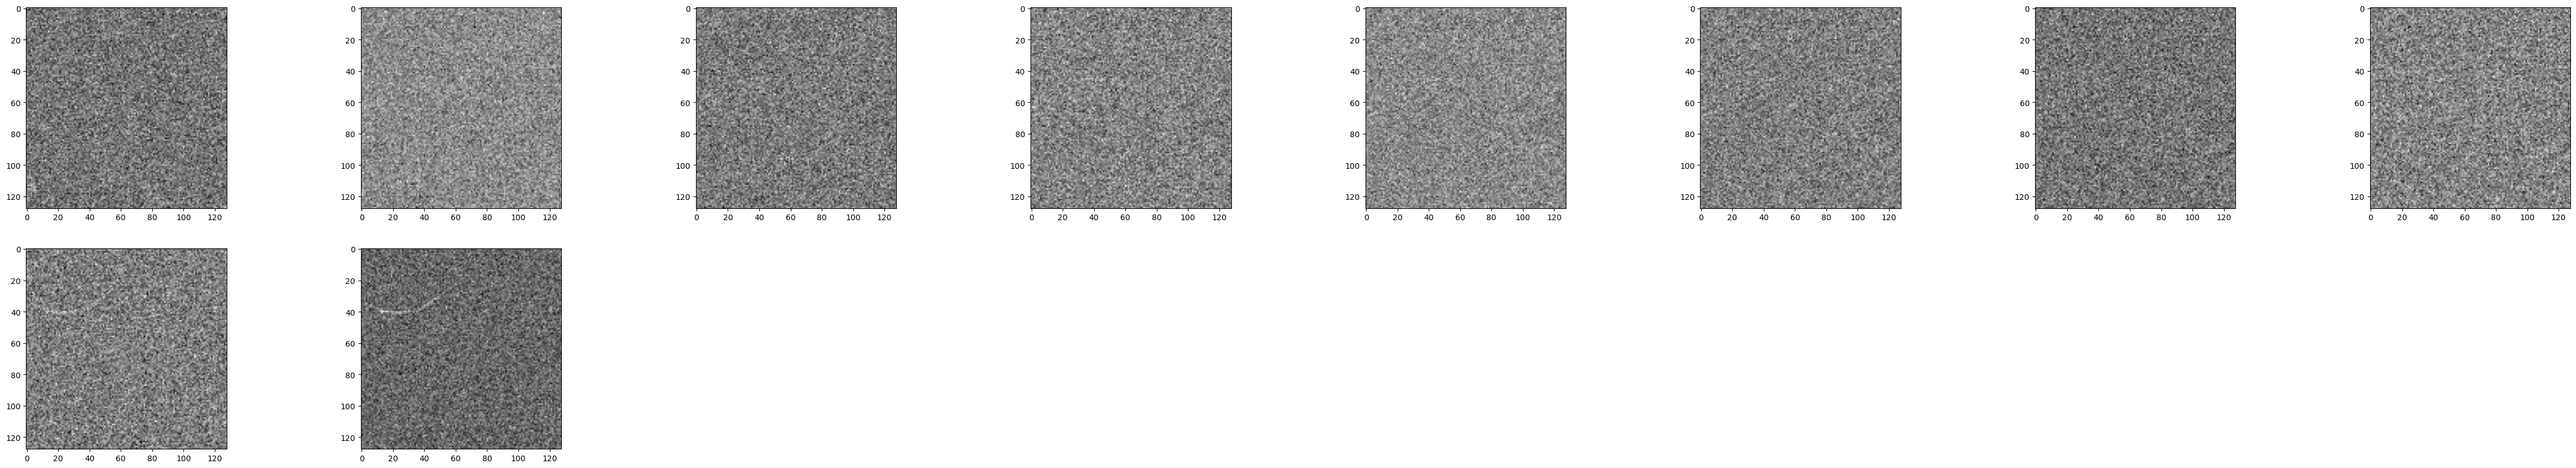

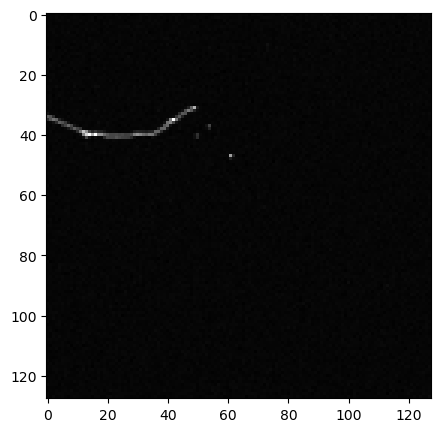

In [20]:
# Visualize reverse process
plt.figure(figsize=(60,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for i, tensor in enumerate(tensor_sample[0]):
    if i % stepsize == 0:
        plt.subplot(int(num_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor), cmap='gray')

plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensor_sample[-1][-1]), cmap='gray')

In [44]:
# Create gif
from PIL import Image

def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
        transforms.Lambda(lambda t: t/t.max())
    ])
    return reverse_transforms(tensor)


images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t,tensor in enumerate(tensor_sample[0]):
    if t % stepsize == 0:
        plt_figure = plt.figure(figsize=(2,2))
        plt.axis('off')
        plt.imshow(image_from_tensor(tensor), cmap='gray')
        plt_figure.canvas.draw()
        image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
        images.append(image)
        plt.close()
images[0].save(gif_dir + '/particles.gif', save_all=True, append_images=images[1:], duration=50)

/tmp/ipykernel_38084/3643176736.py:22: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
